# Data Preprocessing
### Brendon Barrios     |     08/08/2020
Using OSIC Pulmonary Fibrosis Progression dataset from Kaggle.com

<https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview>

## Sentdex Preprocessing Tutorial:
Adapted from: <https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet>

In [27]:
import os
import pydicom
import pandas as pd

DATA_DIR = "train_dl/"
patients = os.listdir(DATA_DIR)

labels_df = pd.read_csv("train_dl.csv", index_col=0)

labels_df.head(10)

,Weeks,FVC,Percent,Age,Sex,SmokingStatus
Patient,,,,,,
ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker


In [71]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

IMAGE_PX_SIZE = 100
NUM_SLICES = 30
SAVE_FILE = "traindata-{}x{}x{}.npy".format(IMAGE_PX_SIZE, IMAGE_PX_SIZE, NUM_SLICES)

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l)/len(l)

def normalize(a):
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm

def process_data(patient, labels_df, img_px_size=50, num_slices=20, visualize=False):
    
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts dicom files by Image Position
    
    new_slices = []
    slices = [cv2.resize(np.array(normalize(each_slice.pixel_array)), (IMAGE_PX_SIZE, IMAGE_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / NUM_SLICES)
    
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    diff = NUM_SLICES - len(new_slices)
    if diff:
        for n in range(diff):
            new_slices.append(new_slices[-1])
        
    if len(new_slices) == NUM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[NUM_SLICES - 1], new_slices[NUM_SLICES]])))
        del new_slices[NUM_SLICES]
        new_slices[NUM_SLICES - 1] = new_val
        
    if len(new_slices) == NUM_SLICES + 1:
        new_val = list(map(mean, zip(*[new_slices[NUM_SLICES - 1], new_slices[NUM_SLICES]])))
        del new_slices[NUM_SLICES]
        new_slices[NUM_SLICES - 1] = new_val
        
    print(len(new_slices))
    
    if visualize:
        fig = plt.figure()
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(5, 6, num+1)
            y.imshow(each_slice, cmap = "gray")
        plt.show
        
    '''
    Obtain FVC Score as label
    '''
    label = labels_df.at[patient, "FVC"]
    print(patient)
        
    return np.array(new_slices), label


In [74]:
print(patients[:5])

['ID00007637202177411956430', 'ID00009637202177434476278', 'ID00010637202177584971671', 'ID00011637202177653955184', 'ID00012637202177665765362']


30
ID00007637202177411956430
30
ID00009637202177434476278
30
ID00010637202177584971671


RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)

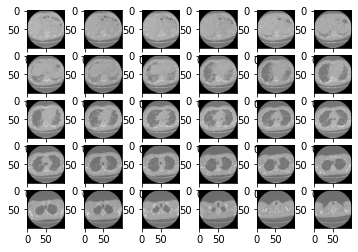

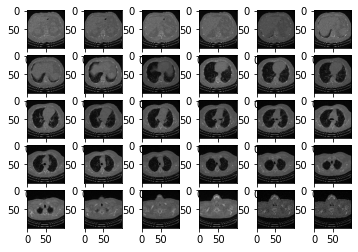

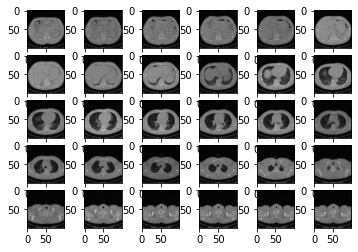

In [73]:
"""
Try Preprocessing Data 
If memory fails: try to process "online", meaning call process_data() while network is training to feed data into network
"""
much_data = []

for num, patient in enumerate(patients[:5]):
    if num%100 == 0 and num != 0:
        print(num)
        
    try:
        img_data, label = process_data(patient, 
                                       labels_df, 
                                       img_px_size=IMAGE_PX_SIZE, 
                                       num_slices=NUM_SLICES, 
                                       visualize=True)
        
        much_data.append([img_data, label])
        
    except KeyError as e:
        print("Unlabeled data!")
        
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

In [62]:
"""
Proof of Save/Load states:
"""
images = np.load(SAVE_FILE, allow_pickle=True)

In [63]:
print("FVC: ", images[0,1][1])

FVC:  2214


In [64]:
print("Normalized Image Data:\n", images[0,0][1])

Normalized Image Data:
 [[-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]
 [-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]
 [-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]
 ...
 [-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]
 [-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]
 [-0.0031526 -0.0031526 -0.0031526 ... -0.0031526 -0.0031526 -0.0031526]]
